In [1]:
import straindesign as sd
import cobra

cobra.Configuration().solver = 'gurobi'
coli = cobra.io.load_model('iML1515')

# Create copy of model to which pathway will be added
coli_PHB = coli.copy()
# If available, set the solver to cplex or gurobi. This will increase the chances
# of sucess enormously
coli_PHB.solver = 'gurobi'

# Change glucose and oxygen uptake, added by me
coli_PHB.reactions.EX_glc__D_e.bounds = -10.5, 1000
coli_PHB.reactions.EX_o2_e.bounds = -15, 1000


# Add metabolites to model
coli_PHB.add_metabolites([ cobra.Metabolite('3hbcoa__R_c'),   # (R)-3-hydroxybutyryl-CoA
                            cobra.Metabolite('3hb_c'),# 3-hydroxybutyrate (cytopl.)
                            cobra.Metabolite('3hb_p'), # 3-hydroxybutyrate (peripl.)
                            cobra.Metabolite('3hb_e'), # 3-hydroxybutyrate (extrac.)
                            ])

# Create reactions
AACOAr    = cobra.Reaction('AACOAr')
PHB       = cobra.Reaction('PHB')
PHBtpp    = cobra.Reaction('PHBtpp')
PHBtex    = cobra.Reaction('PHBtex')
EX_3hb_e  = cobra.Reaction('EX_3hb_e')

# Add reactions to model
coli_PHB.add_reactions([AACOAr,
                         PHB,
                         PHBtpp,
                         PHBtex,
                         EX_3hb_e])

# Define reaction equations
AACOAr.reaction     = '1 aacoa_c + 1 nadph_c + 1 h_c <--> 1 3hbcoa__R_c + 1 nadp_c'
PHB.reaction        = '1 3hbcoa__R_c -> 1 3hb_c + 1 coa_c'
PHBtpp.reaction     = '1 3hb_c <--> 1 3hb_p'
PHBtex.reaction     = '1 3hb_p <--> 1 3hb_e'
EX_3hb_e.reaction   = '1 3hb_e <-->'

# Verify that pathway is operational
sol = sd.fba(coli_PHB,obj='EX_3hb_e',obj_sense='max')
print(f"Maximum possible PHB synthesis rate: {sol.objective_value}.")

Set parameter Username
Academic license - for non-commercial use only - expires 2025-03-01
Read LP format model from file C:\Users\Lenovo\AppData\Local\Temp\tmpipit4kwz.lp
Reading time = 0.01 seconds
: 1877 rows, 5424 columns, 21150 nonzeros
Maximum possible PHB synthesis rate: 12.909217391304423.


In [2]:
exchange_reacs = [r for r in coli_PHB.reactions if all(s<0 for s in r.metabolites.values())]
# shut all exchange fluxes
for r in exchange_reacs:
    r.upper_bound = 0.0

# shut CO2 uptake
coli_PHB.reactions.EX_co2_e.lower_bound    = 0.0

# keep main fermentation products open
coli_PHB.reactions.EX_3hb_e.upper_bound  = 1000.0
coli_PHB.reactions.EX_ac_e.upper_bound     = 1000.0
coli_PHB.reactions.EX_co2_e.upper_bound    = 1000.0
coli_PHB.reactions.EX_etoh_e.upper_bound   = 1000.0
coli_PHB.reactions.EX_for_e.upper_bound    = 1000.0
coli_PHB.reactions.EX_h2_e.upper_bound     = 1000.0
coli_PHB.reactions.EX_h2o2_e.upper_bound   = 1000.0
coli_PHB.reactions.EX_h2o_e.upper_bound    = 1000.0
coli_PHB.reactions.EX_h_e.upper_bound      = 1000.0
coli_PHB.reactions.EX_lac__D_e.upper_bound = 1000.0
coli_PHB.reactions.EX_meoh_e.upper_bound   = 1000.0
coli_PHB.reactions.EX_o2_e.upper_bound     = 1000.0
coli_PHB.reactions.EX_succ_e.upper_bound   = 1000.0
coli_PHB.reactions.EX_tungs_e.upper_bound  = 1000.0
coli_PHB.reactions.DM_4crsol_c.upper_bound = 1000.0
coli_PHB.reactions.DM_5drib_c.upper_bound  = 1000.0
coli_PHB.reactions.DM_aacald_c.upper_bound = 1000.0
coli_PHB.reactions.DM_amob_c.upper_bound   = 1000.0
coli_PHB.reactions.DM_mththf_c.upper_bound = 1000.0
coli_PHB.reactions.DM_oxam_c.upper_bound   = 1000.0

# substitute GPR rule in ATPS4rpp (all genes occur only in ATPS)
atps_genes = [g for g in coli_PHB.reactions.ATPS4rpp.genes]
coli_PHB.reactions.ATPS4rpp.gene_reaction_rule = str(atps_genes[0])
cobra.manipulation.remove_genes(coli_PHB,atps_genes[1:])
atps_genes[0].name = 'atpX'

# substitute GPR rules in NADH16pp, NADH17pp, NADH18pp (all genes occur only in NADHxxpp and GPR rules are identical)
nuo_genes = [g for g in coli_PHB.reactions.NADH16pp.genes]
coli_PHB.reactions.NADH16pp.gene_reaction_rule = str(nuo_genes[0])
coli_PHB.reactions.NADH17pp.gene_reaction_rule = str(nuo_genes[0])
coli_PHB.reactions.NADH18pp.gene_reaction_rule = str(nuo_genes[0])
cobra.manipulation.remove_genes(coli_PHB,nuo_genes[1:])
nuo_genes[0].name = 'nuoX'

# substitute GPR rules in FRD2, FRD3 (genes occur only in FRD2 and FRD3 and GPR rules are identical)
frd_genes = [g for g in coli_PHB.reactions.FRD2.genes]
coli_PHB.reactions.FRD2.gene_reaction_rule = str(frd_genes[0])
coli_PHB.reactions.FRD3.gene_reaction_rule = str(frd_genes[0])
cobra.manipulation.remove_genes(coli_PHB,frd_genes[1:])
frd_genes[0].name = 'frdX'

# substitute GPR rule in CYTBO3_4pp
cyo_genes = [g for g in coli_PHB.reactions.CYTBO3_4pp.genes]
coli_PHB.reactions.CYTBO3_4pp.gene_reaction_rule = str(cyo_genes[0])
cobra.manipulation.remove_genes(coli_PHB,cyo_genes[1:])
cyo_genes[0].name = 'cyoX'

# substitute GPR rule in THD2pp
pnt_genes = [g for g in coli_PHB.reactions.THD2pp.genes]
coli_PHB.reactions.THD2pp.gene_reaction_rule = str(pnt_genes[0])
cobra.manipulation.remove_genes(coli_PHB,pnt_genes[1:])
pnt_genes[0].name = 'pntX'

# substitute GPR rule in PDH and AKGDH
ace_genes = [g for g in coli_PHB.genes if g.name in ['aceE', 'aceF']]
lpd = [g for g in coli_PHB.genes if g.name == 'lpd'][0]
coli_PHB.reactions.PDH.gene_reaction_rule = str(ace_genes[0])+' and '+str(lpd)
cobra.manipulation.remove_genes(coli_PHB,ace_genes[1:])
ace_genes[0].name = 'aceEF'

# substitute GPR rule in SUCOAS
sucCD_genes = [g for g in coli_PHB.reactions.SUCOAS.genes]
coli_PHB.reactions.SUCOAS.gene_reaction_rule = str(sucCD_genes[0])
cobra.manipulation.remove_genes(coli_PHB,sucCD_genes[1:])
sucCD_genes[0].name = 'sucCD'

# substitute GPR rule in SUCDi
sdh_genes = [g for g in coli_PHB.reactions.SUCDi.genes]
coli_PHB.reactions.SUCDi.gene_reaction_rule = str(sdh_genes[0])
cobra.manipulation.remove_genes(coli_PHB,sdh_genes[1:])
sdh_genes[0].name = 'sdhX'

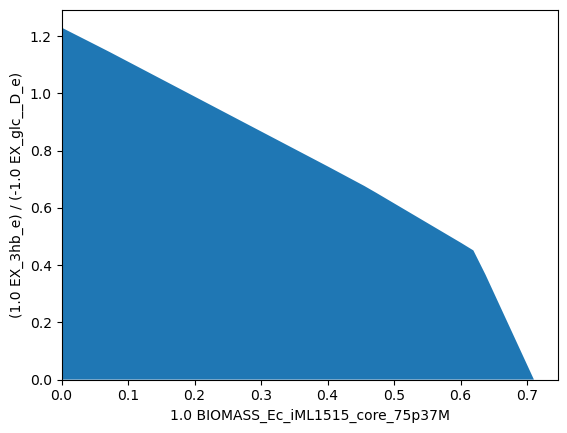

In [3]:
sd.plot_flux_space(coli_PHB, ('BIOMASS_Ec_iML1515_core_75p37M',('EX_3hb_e','-EX_glc__D_e')));

In [3]:
min_3hb_yield = 0.75
min_growth = 0.35
module_suppress = sd.SDModule(coli_PHB,sd.names.SUPPRESS,constraints=f'EX_3hb_e + {min_3hb_yield} EX_glc__D_e <= 0')
module_protect  = sd.SDModule(coli_PHB,sd.names.PROTECT, constraints=f'BIOMASS_Ec_iML1515_core_75p37M>={min_growth}')

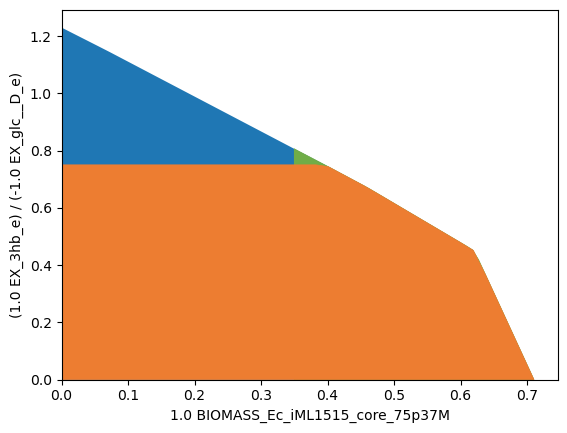

In [5]:
import matplotlib.pyplot as plt
# Wild-type plot
datapoints, triang, plot1 = sd.plot_flux_space(coli_PHB,
                                               ('BIOMASS_Ec_iML1515_core_75p37M',('EX_3hb_e','-EX_glc__D_e')),
                                               show=False);
_,          _,      plot2 = sd.plot_flux_space(coli_PHB,
                                               (f'BIOMASS_Ec_iML1515_core_75p37M',('EX_3hb_e','-EX_glc__D_e')),
                                               constraints=f'BIOMASS_Ec_iML1515_core_75p37M >= {min_growth}',
                                               show=False);
plot2.set_facecolor('#70AD47')
plot2.set_edgecolor('#70AD47')
# pGCP design plot
_,          _,      plot3 = sd.plot_flux_space(coli_PHB,
                                               ('BIOMASS_Ec_iML1515_core_75p37M',('EX_3hb_e','-EX_glc__D_e')),
                                               # The sign of the glucose exchange reaction is flipped since
                                               # reaction is defined in the direction of secretion.
                                               constraints=f'EX_3hb_e + {min_3hb_yield} EX_glc__D_e <= 0',
                                               show=False);
plot3.set_facecolor('#ED7D31')
plot3.set_edgecolor('#ED7D31')
# adjust axes limits and show plot
plot3.axes.set_xlim(0, 1.05*max([a[0] for a in datapoints]))
plot3.axes.set_ylim(0, 1.05*max([a[1] for a in datapoints]))
plt.show()

In [4]:
import logging
logging.basicConfig(level=logging.INFO)

# allow all gene knockouts except for spontanuos
gko_cost = {g.name:1 for g in coli_PHB.genes}
gko_cost.pop('s0001')

# possible knockout of O2
ko_cost = {'EX_o2_e': 1}

# Compute strain designs
sols = sd.compute_strain_designs(coli_PHB,
                                 sd_modules = [module_suppress, module_protect],
                                 max_solutions = 1,
                                 max_cost = 50,
                                 ko_cost = ko_cost,
                                 gko_cost = gko_cost,
                                 solution_approach = sd.names.ANY)
# Print solutions
print(f"One compressed solution with cost {sols.sd_cost[0]} found and "+\
      f"expanded to {len(sols.reaction_sd)} solutions in the uncompressed network.")
print(f"Example intervention set: {['+'+s if v>0 else '-'+s for s,v in sols.gene_sd[0].items() if v!=0]}")

INFO:root:Preparing strain design computation.
INFO:root:  Using gurobi for solving LPs during preprocessing.
INFO:root:  FVA to identify blocked reactions and irreversibilities.
INFO:root:  FVA(s) to identify essential reactions.
INFO:root:Preprocessing GPR rules (1484 genes, 2266 gpr rules).
INFO:root:  Simplifyied to 1229 genes and 1856 gpr rules.
INFO:root:  Extending metabolic network with gpr associations.
INFO:root:Compressing Network (5248 reactions).
INFO:root:  Removing blocked reactions.
INFO:root:  Translating stoichiometric coefficients to rationals.
INFO:root:  Removing conservation relations.
INFO:root:  Compression 1: Applying compression from EFM-tool module.
INFO:root:  Reduced to 2448 reactions.
INFO:root:  Compression 2: Lumping parallel reactions.
INFO:root:  Reduced to 2339 reactions.
INFO:root:  Compression 3: Applying compression from EFM-tool module.
INFO:root:  Reduced to 2296 reactions.
INFO:root:  Compression 4: Lumping parallel reactions.
INFO:root:  Reduce

In [ ]:
print(f"the solutions are: {sols.reaction_sd} ")

In [ ]:
import matplotlib.pyplot as plt
# Wild-type plot
datapoints, triang, plot1 = sd.plot_flux_space(coli_PHB,
                                               ('BIOMASS_Ec_iML1515_core_75p37M',('EX_3hb_e','-EX_glc__D_e')),
                                               show=False);
_,          _,      plot2 = sd.plot_flux_space(coli_PHB,
                                               ('BIOMASS_Ec_iML1515_core_75p37M',('EX_3hb_e','-EX_glc__D_e')),
                                               constraints=f'BIOMASS_Ec_iML1515_core_75p37M>={min_growth}',
                                               show=False);
plot2.set_facecolor('#70AD47')
plot2.set_edgecolor('#70AD47')
# pGCP design plot
_,          _,      plot3 = sd.plot_flux_space(coli_PHB,
                                               ('BIOMASS_Ec_iML1515_core_75p37M',('EX_3hb_e','-EX_glc__D_e')),
                                               # The sign of the glucose exchange reaction is flipped since
                                               # reaction is defined in the direction of secretion.
                                               constraints=f'EX_3hb_e + {min_3hb_yield} EX_glc__D_e <= 0',
                                               show=False);
plot3.set_facecolor('#ED7D31')
plot3.set_edgecolor('#ED7D31')
# plotting designed strain
interventions = [[{s:1.0},'=',0.0] for s,v in sols.reaction_sd[0].items() if v < 1]
_,          _,      plot4 = sd.plot_flux_space(coli_PHB,
                                               ('BIOMASS_Ec_iML1515_core_75p37M',('EX_3hb_e','-EX_glc__D_e')),
                                               # The sign of the glucose exchange reaction is flipped since
                                               # reaction is defined in the direction of secretion.
                                               constraints=interventions,
                                               show=False);
plot4.set_facecolor('#FFC000')
plot4.set_edgecolor('#FFC000')
# adjust axes limits and show plot
plot4.axes.set_xlim(0, 1.05*max([a[0] for a in datapoints]))
plot4.axes.set_ylim(0, 1.05*max([a[1] for a in datapoints]))
plt.show()